In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm_notebook as tqdm
import re
tqdm.pandas()
from collections import defaultdict

In [2]:
os.chdir('C:/Users/wissam_T/Desktop/5th/2nd semester/ml + dm')

In [3]:
def null_with_percentage(dataframe):
    null_counts = dataframe.isnull().sum()
    null_percentages = (dataframe.isnull().sum() / len(dataframe)) * 100
    null_analysis = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentages
    }).sort_values(by='Null Percentage', ascending=False)

    print("Null Value Counts and Percentages per Column:")
    print(null_analysis)
    print("\n" + "="*70 + "\n")

In [4]:
og_vehicles_df = pd.read_csv("data/vehicles.csv") 

In [5]:
from sklearn.model_selection import train_test_split

# Test being the final testing data
train_val, test = train_test_split(og_vehicles_df, test_size=0.2, random_state=42)

In [6]:
#train is the data we will work on
#val is the data we will validate on before testing
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [7]:
train_X = train.drop('price', axis=1) 
train_y = train['price']

In [8]:
# 1. Create a unique index (if it's not already present)
train_X = train_X.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

# 2. Add an index column
train_X['row_index'] = train_X.index
train_y = train_y.reset_index(drop=True)
train_y = pd.DataFrame(train_y)  # if it's a Series, make it a DataFrame
train_y['row_index'] = train_y.index

In [ ]:
from wordcloud import WordCloud

text = ' '.join(train_X['description'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions")
plt.show()

In [9]:
class CarPreprocessor:
    def __init__(self):
        # Initialize any mappings or regex patterns here
        self.mileage_patterns = [
            # Standard patterns
            r'(\d{1,3}(?:,\d{3})*)\s*miles',  # 85,000 miles
            r'(\d{1,3}(?:,\d{3})*)\s*mi',     # 120,000 mi
            r'(\d+)\s*k\s*miles',              # 120k miles
            r'(\d+)\s*k\s*mi',                 # 85k mi
            r'(\d+)\s*k\b',                    # 120k
            
            # Enhanced patterns
            r'mileage:\s*(\d{1,3}(?:,\d{3})*)',
            r'odometer:\s*(\d{1,3}(?:,\d{3})*)',
            r'\b(\d{3})\s*k\b',                # 150k (3-digit)
            r'(\d+)\s*thousand\s*miles',
            r'(\d+)\s*kmiles',                 # 150kmiles
            r'(\d+)\s*,\s*(\d{3})\s*miles',    # 12,345 miles (capture both groups)
            r'approx\s*(\d+)\s*k',             # approx 120k
            r'~(\d+)\s*k',                     # ~120k
            r'around\s*(\d+)\s*k\s*miles',
            r'original\s*miles:\s*(\d+)',
            r'actual\s*miles:\s*(\d+)',
            r'\b(\d+)km?\b',                   # European style 150k
            r'(\d+)\s*[km]?\s*(?:miles|mi)',
            
            # German/European variants
            r'(\d{1,3}(?:\.\d{3})*\s*km)',    # 85.000 km
            r'(\d+)\s*tkm'                     # 150tkm (German thousands)
        ]
        self.transmission_map = {
        'automatic': [
            'auto', 'automatic', 'a/t', 'at', 'shiftless', 'self-shifting',
            'triptonic', 'steptronic', 'automanual', 'manumatic',
            'dual clutch', 'dsg', 'pdks', 's tronic', 'dct', 'speedshift',
            'powershift', 'multitronic', 'tiptronic', 'sportronic'
        ],
        'manual': [
            'manual', 'stick', 'm/t', 'mt', 'standard', '4-speed', '5-speed',
            '6-speed', 'clutch', 'h-pattern', 'floor shift', 'column shift',
            '3-pedal', 'three pedal', 'shift your own'
        ],
        'cvt': [
            'cvt', 'continuously variable', 'varitronic', 'xtronic',
            'ecvt', 'ivt', 'smartshift', 'hypertronic'
        ],
        'automated_manual': [
            'automated manual', 'amt', 'e-clutch', 'semi-auto',
            'clutchless manual', 'sequential'
        ],
        'other': [
            'direct drive', 'single speed', 'preselector', 'hydrostatic',
            'ivtm', 'torque converter'
        ]
    }
        self.drive_map = {
        'fwd': [
            'front wheel', 'fwd', 'front drive', '2wd', 'two wheel',
            'front-wheel', 'f.w.d.', 'f w d', 'forward wheel'
        ],
        'rwd': [
            'rear wheel', 'rwd', 'rear drive', '2wd', 'two wheel',
            'rear-wheel', 'r.w.d.', 'r w d', 'back wheel'
        ],
        'awd': [
            'all wheel', 'awd', '4matic', 'quattro', 'xdrive', 'sh-awd',
            '4motion', 'symmetrical awd', 'super handling awd', 's-awd',
            'torque vectoring', 'torsen', 'haldex', 'on-demand', 'full-time 4wd',
            'permanent 4wd', '4matic+', 'quattro ultra', 'dynamic torque vectoring'
        ],
        '4wd': [
            'four wheel', '4wd', '4x4', 'part-time 4wd', 'selectable 4wd',
            'shift-on-the-fly', '4 wheel drive', '4-wheel', 'four-by-four',
            '4 wd', '4 by 4', '4x4 system', '4x4 drivetrain'
        ],
        'unknown': [
            'unspecified', 'unknown', 'not specified', '?'
        ]}
        self.color_map = defaultdict(list, {
        'white': [
            'white', 'pearl', 'ivory', 'alabaster', 'chalk', 'coconut', 'diamond',
            'frost', 'glacier', 'moonstone', 'opal', 'seashell', 'snow', 'whisper',
            'cream', 'eggshell', 'vanilla', 'porcelain', 'pearl white', 'triple white'
        ],
        'black': [
            'black', 'onyx', 'ebony', 'obsidian', 'phantom', 'raven', 'sable',
            'shadow', 'vader', 'midnight', 'cosmic', 'licorice', 'piano', 'tuxedo',
            'jet', 'carbon', 'graphite', 'black sapphire', 'black noir'
        ],
        'silver': [
            'silver', 'platinum', 'metallic gray', 'brushed metal', 'steel',
            'chrome', 'argent', 'polished', 'mercury', 'moonlight silver'
        ],
        'gray': [
            'gray', 'grey', 'graphite', 'charcoal', 'ash', 'slate', 'stone',
            'cement', 'granite', 'smoke', 'pewter', 'storm', 'concrete', 'titanium'
        ],
        'red': [
            'red', 'ruby', 'burgundy', 'cherry', 'scarlet', 'maroon', 'crimson',
            'garnet', 'fire red', 'candy apple', 'vermilion', 'blood red', 'wine'
        ],
        'blue': [
            'blue', 'navy', 'sapphire', 'aqua', 'teal', 'cobalt', 'sky blue',
            'midnight blue', 'turquoise', 'steel blue', 'indigo', 'denim', 'arctic'
        ],
        'green': [
            'green', 'emerald', 'forest', 'lime', 'mint', 'olive', 'jade',
            'army green', 'seafoam', 'moss', 'avocado', 'sage', 'pine'
        ],
        'brown': [
            'brown', 'tan', 'bronze', 'copper', 'champagne', 'beige', 'mocha',
            'chocolate', 'espresso', 'cinnamon', 'pecan', 'rust', 'caramel', 'nutmeg'
        ],
        'gold': [
            'gold', 'amber', 'honey', 'topaz', 'saffron', 'sunstone', 'champagne gold'
        ],
        'yellow': [
            'yellow', 'mustard', 'lemon', 'sunflower', 'banana', 'dandelion',
            'canary', 'butter'
        ],
        'orange': [
            'orange', 'tangerine', 'coral', 'amber orange', 'burnt orange',
            'copper orange', 'pumpkin', 'sunset'
        ],
        'purple': [
            'purple', 'violet', 'plum', 'lavender', 'amethyst', 'orchid',
            'grape', 'wine purple', 'deep purple'
        ],
        'custom': [
            'matte', 'metallic', 'chrome', 'primer', 'wrapped', 'plasti-dip',
            'color changing', 'chameleon', 'two-tone', 'murdered out', 'stealth',
            'patina', 'rat rod', 'primer gray', 'custom paint', 'graphics',
            'wrap', 'fade', 'flip-flop', 'iridescent'
        ]
    })
        
        
        self.vehicle_type_map = {
        'sedan': [
            'sedan', 'saloon', '4-door', 'four door', 'notchback', 'fastback',
            'hardtop', 'post sedan', 'club sedan', 'berline', 'limousine'
        ],
        'SUV': [
            'suv', 'sport utility', 'crossover', 'jeep', 'xuv', 'sav', 'sport activity',
            'soft-roader', 'off-road', '4x4', 'high rider', 'raised', 'command driving',
            'urban cruiser'
        ],
        'truck': [
            'truck', 'pickup', 'pick-up', 'ute', 'dual cab', 'single cab', 'crew cab',
            'flatbed', 'dumper', 'box truck', 'haul truck', 'lifted truck',
            'work truck', 'chassis cab', 'trailering', 'utility truck'
        ],
        'coupe': [
            'coupe', 'coupé', '2-door', 'two door', 'sport coupe', 'notchback coupe',
            'performance coupe'
        ],
        'hatchback': [
            'hatchback', 'hatch', '3-door', '5-door', 'liftback', 'compact hatch',
            'hot hatch'
        ],
        'wagon': [
            'wagon', 'estate', 'touring', 'sport wagon', 'station wagon', 'longroof',
            'shooting brake', 'family wagon'
        ],
        'van': [
            'van', 'minivan', 'mpv', 'passenger van', 'cargo van', 'work van',
            'sprinter', 'panel van', 'shuttle van', 'family van', 'transit'
        ],
        'convertible': [
            'convertible', 'cabriolet', 'roadster', 'drop-top', 'soft top', 'ragtop',
            'open top', 'spyder', 'volante'
        ],
        'exotic': [
            'supercar', 'hypercar', 'exotic', 'gt', 'grand tourer', 'spider',
            'barchetta', 'speedster', 'targa', 'lambo', 'ferrari', 'rare import'
        ],
        'other': [
            'buggy', 'dune buggy', 'motorhome', 'rv', 'golf cart', 'side-by-side',
            'atv', 'utv', 'kart', 'classic', 'kit car'
        ]
    }
        self.size_patterns = [
        # Subcompact and Mini
        (r'\bsub[\s\-]?compact\b', 'subcompact'),
        (r'\bmini\b', 'subcompact'),
        (r'\bmicro\b', 'subcompact'),
        (r'\bkei car\b', 'subcompact'),
        (r'\bcity car\b', 'subcompact'),
        (r'\btiny\b', 'subcompact'),
        (r'\bvery small\b', 'subcompact'),
    
        # Compact
        (r'\bcompact\b', 'compact'),
        (r'\bsmall\b', 'compact'),
        (r'\b5[\s\-]?door hatch\b', 'compact'),
        (r'\bcompact suv\b', 'compact'),
        (r'\bentry level\b', 'compact'),
    
        # Mid-size
        (r'\bmid[\s\-]?size\b', 'mid-size'),
        (r'\bintermediate\b', 'mid-size'),
        (r'\bmedium\b', 'mid-size'),
        (r'\bstandard\b', 'mid-size'),
        (r'\baverage size\b', 'mid-size'),
        (r'\bmidsize suv\b', 'mid-size'),
    
        # Full-size
        (r'\bfull[\s\-]?size\b', 'full'),
        (r'\blarge\b', 'full'),
        (r'\bexecutive\b', 'full'),
        (r'\bfamily size\b', 'full'),
        (r'\bfull size truck\b', 'full'),
        (r'\boversized\b', 'full'),
    
        # Extra large / extended
        (r'\bxl\b', 'extra-large'),
        (r'\bextra[\s\-]?large\b', 'extra-large'),
        (r'\bextended\b', 'extra-large'),
        (r'\blwb\b', 'extra-large'),  # Long wheelbase
        (r'\bcrew cab\b', 'extra-large'),
        (r'\bmega cab\b', 'extra-large'),
    
        # Engine displacement (proxy for size)
        (r'\b\d\.\d\s*l\b', 'large'),
        (r'\b\d{1,2}\s*valve\b', 'large'),
        (r'\bv[\-]?\d\b', 'large'),
        (r'\b(v6|v8|v10|v12)\b', 'large'),
    
        # Marketing classes
        (r'\bfull[\s\-]?sized luxury\b', 'full'),
        (r'\bcompact crossover\b', 'compact'),
        (r'\bmini[\s\-]?suv\b', 'subcompact'),
        (r'\bmidsize crossover\b', 'mid-size'),
        (r'\bthree[-\s]?row\b', 'extra-large'),
        ]
        self.cylinder_patterns = [
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(\d)\s*(?:cyl|cylinder)s?\b', lambda m: f"{m.group(1)} cylinders"),  # 4 cyl
        (r'\b(\d)\s*[\-]?speed\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
        (r'\b(\d\.\d)L\b', lambda m: '6 cylinders' if float(m.group(1)) >= 3.0 else '4 cylinders'),
        (r'\b(\d)\s*[\-]pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(rotary|wankel)\b', lambda m: 'rotary'),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # N55 → 6
        (r'\b(ls\d+)\b', lambda m: '8 cylinders'),  # LS engines are V8s
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # RB series are I6
        (r'\b(1uz|2uz|3uz)\b', lambda m: '8 cylinders'),  # Toyota UZ series
        (r'\b(k\d+[a-z]*)\b', lambda m: '4 cylinders'),  # K20, K24 are I4
        (r'\b(ej\d+)\b', lambda m: '4 cylinders'),  # Subaru EJ series
        (r'\b(sr\d+[a-z]*)\b', lambda m: '4 cylinders'),  # SR20DET etc
        (r'\b(13b|20b)\b', lambda m: 'rotary'),  # Mazda rotary
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(\d)\s*cyl\b', lambda m: f"{m.group(1)} cylinders"),
        (r'\b(\d)\s*pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(\d)\s*spd\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4, 6, 8] else None),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n20|n55)\b', lambda m: '4 cylinders' if m.group(1)[1:] == '20' else '6 cylinders'),
        (r'\b(ls\d)\b', lambda m: '8 cylinders'),  # LS engines
        (r'\b(2jz|7m)\b', lambda m: '6 cylinders'),  # Toyota engines
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # Nissan RB series
        (r'\b(13b|20b)\b', lambda m: 'rotary')  # Mazda rotary
        ]
        self.fuel_map = {
        'gas': ['gas', 'gasoline', 'petrol'],
        'diesel': ['diesel'],
        'electric': ['electric', 'ev'],
        'hybrid': ['hybrid', 'plug-in hybrid', 'phev'],
        'other': ['flex fuel', 'ethanol', 'lpg']
        }
        self.brands = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'bmw', 'mercedes', 'mazda', 'jeep',
              'subaru', 'hyundai', 'kia', 'audi', 'vw', 'volkswagen', 'dodge', 'ram', 'gmc', 'lexus', 'chrysler']
        self.condition_map = {
        # New / Like New
        'new': [
            'brand new', 'factory new', 'showroom new', 'never driven', 
            'zero miles', '0 miles', 'still in wrapper', 'with tags',
            'never titled', 'dealer fresh'
        ],
        'like new': [
            'like new', 'as new', 'near new', 'basically new', 'almost new',
            'barely used', 'gently used', 'lightly used', 'hardly used',
            'looks new', 'appears new', 'mint condition', 'pristine',
            'used but looks new', 'perfect condition'
        ],
        
        # Excellent
        'excellent': [
            'excellent', 'exceptional', 'immaculate', 'flawless', 'showroom quality',
            'well maintained', 'serviced regularly', 'garage kept', 'adult owned',
            'no issues', 'no problems', 'runs perfect', 'mechanically sound',
            'clean inside out', 'no accidents', 'no damage', 'no dents',
            'no scratches', 'no rust'
        ],
        
        # Good
        'good': [
            'good', 'good condition', 'runs good', 'runs great', 'drives well',
            'solid condition', 'minor wear', 'normal wear', 'well cared for',
            'maintained', 'some wear', 'age appropriate', 'nice condition',
            'clean title', 'no major issues', 'minor cosmetic', 'small scratches',
            'few dings'
        ],
        
        # Fair
        'fair': [
            'fair', 'fair condition', 'average condition', 'needs some work',
            'minor issues', 'cosmetic issues', 'runs but needs', 'requires tlc',
            'mechanically ok', 'body issues', 'interior wear', 'high miles',
            'mileage wear', 'old but runs', 'used daily', 'project car',
            'could use', 'peeling paint', 'faded'
        ],
        
        # Salvage / Poor
        'salvage': [
            'salvage', 'rebuilt', 'reconstructed', 'total loss', 'insurance loss',
            'flood car', 'water damage', 'hail damage', 'frame damage',
            'mechanical issues', 'engine problems', 'transmission issues',
            'doesn\'t run', 'won\'t start', 'for parts', 'parts only',
            'non-op', 'non operational', 'project only', 'needs engine',
            'needs transmission', 'needs repair', 'as is', 'junk title',
            'scrap', 'not drivable'
        ],
        
        # Special Cases
        'certified': [
            'certified', 'cpo', 'manufacturer certified', 'dealer certified',
            'warranty', 'extended warranty'
        ],
        'modified': [
            'modified', 'custom', 'upgraded', 'aftermarket', 'performance parts',
            'turbocharged', 'supercharged', 'built engine', 'stance', 'lowered',
            'lifted', 'big tires'
        ]}
        self.year_patterns = [
        # Priority patterns (most specific first)
        r'\bmy\s*(\d{4})\b',  # MY2015
        r'\bmfg\s*[:\.]?\s*(\d{4})',  # MFG:2010
        r'\bmodel\s*year\s*[:\.]?\s*(\d{4})',
        r'\bmanufactured\s*[:\.]?\s*(\d{4})',
        r'\bfirst\s*registered\s*[:\.]?\s*(\d{4})',
        r'\bproduction\s*date\s*[:\.]?\s*(\d{4})',
        r'\bbuilt\s*[:\.]?\s*(\d{4})',
        
        # General patterns
        r'\b(19[5-9]\d|20[0-3]\d|202[4-5])\b',  # Standard years
        r'\b(?:yr|year)\s*[:\.]?\s*(\d{4})',
        r'\b(?:early|late)\s*(\d{4})s?',  # early 2000s
        r'\b(\d{4})\s*model\b',
        r'\b(\d{4})\s*-\s*(\d{4})\b'  # Year ranges
        ]
        self.engine_size_map = {
        '1.0L': '3 cylinders', '1.2L': '3 cylinders',
        '1.4L': '4 cylinders', '1.5L': '4 cylinders',
        '1.6L': '4 cylinders', '1.8L': '4 cylinders',
        '2.0L': '4 cylinders', '2.4L': '4 cylinders',
        '2.5L': '4 cylinders', '3.0L': '6 cylinders',
        '3.5L': '6 cylinders', '4.0L': '8 cylinders',
        '5.0L': '8 cylinders', '6.0L': '12 cylinders'
        }
        self.type_cylinder_map = {
        'sedan': '4 cylinders',
        'compact': '4 cylinders',
        'coupe': '6 cylinders',
        'SUV': '6 cylinders',
        'truck': '8 cylinders',
        'van': '6 cylinders',
        'convertible': '6 cylinders',
        'hatchback': '4 cylinders'
        }
        self.manufacturer_defaults = {
            'toyota': '4 cylinders',
            'ford': '6 cylinders',
            'bmw': '4 cylinders',
            'chevrolet': '8 cylinders',
        }
        self.    ev_makes = {
        'tesla', 'rivian', 'lucid', 'fisker', 'polestar', 
        'nio', 'xpeng', 'li auto', 'byton', 'faraday future'
        }
        # Model patterns indicating EVs
        self.ev_model_patterns = [
        r'\be-?\d',                # e-tron, e6, e-golf
        r'\bvolt\b',               # Chevy Volt
        r'\bbolt\b',               # Chevy Bolt
        r'\bleaf\b',               # Nissan Leaf
        r'\bion(?:iq)?\b',         # Hyundai Ioniq/Ioniq5
        r'\bev\b',                 # Model EV
        r'\belectr',               # Electric, Electra
        r'\bphev\b',               # Plug-in Hybrid
        r'\bzoe\b',                # Renault Zoe
        r'\bmodel [s3xy]',         # Tesla Models
        r'\bid\b',                 # VW ID.4
        r'\b(?:\d+)i\b',           # BMW i3, i8
        r'\bmirai\b',              # Toyota Mirai
        r'\bmustang mach-e\b',     # Ford Mustang Mach-E
        ]
        # Description keywords
        self.ev_desc_keywords = [
            'electric vehicle', 'zero emission', 'battery powered',
            'ev range', 'kwh battery', 'plug in', 'charger included',
            'supercharger', 'wall connector'
        ]
        self._progress = None  # Will hold our progress bar reference
        
        
    def preprocess(self, df):
        """Main preprocessing pipeline with consistent progress bars"""
        # Initialize ONE main progress bar
        total_steps = 7  # Update this if steps change
        main_progress = tqdm(total=total_steps, 
                            desc="Overall Progress", 
                            position=0,  # Critical for proper spacing
                            leave=True,
                            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
                            ncols=100)
        
        try:
            df = df.copy()
            
            # Step 1: Column dropping
            main_progress.set_description("Dropping columns")
            cols_to_drop = ['id', 'url', 'region_url', 'county', 'image_url', 'posting_date', 'VIN', 'region']
            df = df.drop(columns=cols_to_drop, errors='ignore')
            main_progress.update(1)
            
            # Step 2: Fill nulls
            main_progress.set_description("Filling model info")
            df = self.filling_nulls_from_other_rows_model_info(df)
            main_progress.update(1)
            
            # Step 3: Feature extraction
            main_progress.set_description("Extracting features")
            df = self._extract_features_with_progress(df, main_progress)
            
            # Step 4: Geocoding
            main_progress.set_description("Geocoding")
            df = self.fill_lat_lon_by_state(df)
            main_progress.update(1)
            
            # Remaining steps
            steps = [
                (self._process_electric_vehicles, "Processing EVs"),
                (self._process_cylinders, "Processing cylinders"),
                (self._process_conditions, "Processing conditions"),
                (self.handle_outliers, "Processing outliers"),
                (self._smart_imputation, "applying smart imputation"),
                (self._final_cleaning, "Final cleaning")
            ]
            
            for func, desc in steps:
                main_progress.set_description(desc)
                df = func(df)
                main_progress.update(1)
                
            return df
        finally:
            main_progress.close()
            
    def _smart_imputation(self, df):
        """
        Strategic imputation that:
        - Only drops rows where critical fields are missing
        - Uses careful odometer imputation
        """
    
        # ---- Critical columns where missing rows should be dropped ----
        critical_cols = ['title_status', 'manufacturer', 'model']
        df = df.dropna(subset=critical_cols).copy()  # Drop and re-copy to avoid warnings
    
        # ---- Odometer: Conditional Imputation ----
        if 'odometer' in df.columns and 'year' in df.columns:
            recent_mask = (df['year'] >= (pd.Timestamp.now().year - 10)) & df['odometer'].isna()
    
            grouped_median = df.groupby(['manufacturer', 'model', 'year'])['odometer'].median()
            df.loc[recent_mask, 'odometer'] = df.loc[recent_mask].apply(
                lambda row: grouped_median.get((row['manufacturer'], row['model'], row['year']), np.nan),
                axis=1
            )
    
            # Create an indicator column for whether odometer was imputed
            df.loc[:, 'odometer_imputed'] = df['odometer'].isna().astype(int)
            
        df['log_odometer'] = np.log1p(df['odometer'])

    
        # ---- Year: Bounded Imputation ----
        if 'year' in df.columns:
            mask = df['year'].isna()
            median_by_group = df.groupby(['manufacturer', 'model'])['year'].median().clip(lower=1980, upper=pd.Timestamp.now().year)
            df.loc[mask, 'year'] = df.loc[mask].apply(
                lambda row: median_by_group.get((row['manufacturer'], row['model']), np.nan),
                axis=1
            )
    
        # ---- Drop rows with remaining missing odometer or year ----
        df = df.dropna(subset=['year', 'odometer']).copy()
    
        # ---- Categorical: Manufacturer-Specific ----
        cat_cols = ['size', 'paint_color', 'drive', 'type', 'fuel', 'transmission']
        for col in cat_cols:
            if col in df.columns:
                df[col] = df.groupby(['manufacturer', 'model'])[col].transform(
                    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
                )
                df[col] = df[col].fillna(df[col].mode()[0])
    
        # ---- Numeric: Conditional Median ----
        num_cols = ['cylinders_numeric', 'lat', 'long']
        for col in num_cols:
            if col in df.columns:
                if col == 'cylinders_numeric':
                    df[col] = df.groupby('type')[col].transform(lambda x: x.fillna(x.median()))
                df[col] = df[col].fillna(df[col].median())
                
        df = df.dropna(subset=['cylinders_numeric']).copy()
    
        # ---- Recalculate Derived Fields ----
        if 'mileage_condition' in df.columns:
            df['mileage_condition'] = pd.cut(
                df['odometer'],
                bins=[1000, 25000, 75000, 175000, 350000, 600000, float('inf')],
                labels=['new', 'like new', 'excellent', 'good', 'fair', 'salvage'],
                right=False
            )
    
        return df

    def _extract_features_with_progress(self, df, main_progress):
        """Feature extraction with sub-progress that doesn't conflict"""
        columns_to_fill = [
            'odometer', 'transmission', 'drive', 'paint_color',
            'type', 'size', 'cylinders', 'fuel', 'manufacturer',
            'year', 'condition'
        ]
        
        with tqdm(total=len(columns_to_fill), desc="Extracting features", position=1, leave=False) as sub_progress:
            for column in columns_to_fill:
                mask = df[column].isna()
                df.loc[mask, column] = df[mask].progress_apply(
                    lambda row: self.safe_extract(row, column),
                    axis=1
                )
                sub_progress.update(1)
        
        main_progress.update(1)
        return df
    
    def filling_nulls_from_other_rows_model_info(self, df):
        
        # Step 1: Group by model and calculate mode (most common values) for categorical columns
        model_based_fill = df.groupby('model').agg({
        'manufacturer': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'cylinders': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'fuel': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'transmission': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'drive': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'size': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'year': lambda x: x.mode()[0] if not x.mode().empty else np.nan,    
        }).reset_index()

        # Step 2: Merge with original data to fill nulls
        for column in ['manufacturer', 'cylinders', 'fuel',
                   'transmission', 'drive', 'size', 'type', 'year']:
            df[column] = df[column].fillna(df.merge(model_based_fill, on='model', how='left')[f'{column}_y'])
        
        return df  
    
    def _process_electric_vehicles(self, df):
        """Handle electric vehicle specific processing"""
        # Ensure fuel column exists
        if 'fuel' not in df.columns:
            df['fuel'] = np.nan
            
        # Identify EVs
        ev_mask = self.identify_electric_vehicles(df)
        df.loc[ev_mask, 'fuel'] = 'electric'
        df.loc[ev_mask, 'cylinders'] = 'electric'
        return df
    
    def _process_cylinders(self, df):
        """Process cylinder information"""
        # Ensure required columns exist
        for col in ['cylinders', 'type', 'manufacturer']:
            if col not in df.columns:
                df[col] = np.nan
                
        # Fill missing cylinders
        df = self.fill_cylinders(df)
        
        # Reclassify 'other' cylinders
        mask = df['cylinders'].isin(['other', None, np.nan])
        df.loc[mask, 'cylinders'] = df.loc[mask].apply(
            self.reclassify_other_cylinders,
            axis=1
        )
        
        # Convert to numeric
        df['cylinders_numeric'] = df['cylinders'].apply(
            self.convert_cylinders_to_numeric
        )
        
        valid_cylinder_set = {3, 4, 5, 6, 8, 10, 12, 0}
        df['cylinders_numeric'] = df['cylinders_numeric'].where(
            df['cylinders_numeric'].isin(valid_cylinder_set),
            np.nan
        )
        
        return df
    
    def _process_conditions(self, df):
        """Process vehicle conditions"""
        if 'condition' not in df.columns:
            df['condition'] = np.nan
            
        df = self.estimate_condition_by_mileage(df)
        df = self.fill_condition_with_context(df)
        
        return df
    
    def _final_cleaning(self, df):
        """Final cleaning steps"""
        # Handle EVs
        df['is_electric'] = (df['fuel'] == 'electric').astype(int)
        
        df.drop(columns=['description'], inplace=True, errors='ignore')
        
        # Clean up
        if 'cylinders' in df.columns:
            df.drop(columns=['cylinders'], inplace=True)
            
        return df
    
    def fill_lat_lon_by_state(self, df):
        """Fill missing lat/long values using the average coordinates per state"""
        # Ensure required columns exist
        if not {'state', 'lat', 'long'}.issubset(df.columns):
            raise ValueError("DataFrame must contain 'state', 'lat', and 'long' columns")
    
        # Compute average lat/lon per state
        state_coords = df.dropna(subset=['lat', 'long']).groupby('state')[['lat', 'long']].mean()
    
        # Create masks for missing values
        missing_lat = df['lat'].isna()
        missing_long = df['long'].isna()
    
        # Fill missing latitudes
        df.loc[missing_lat, 'lat'] = df.loc[missing_lat, 'state'].map(state_coords['lat'])
    
        # Fill missing longitudes
        df.loc[missing_long, 'long'] = df.loc[missing_long, 'state'].map(state_coords['long'])
    
        return df
    
    def _ensure_column_exists(self, df, column, default_value=np.nan):
        if column not in df.columns:
            df[column] = default_value
        return df
        
    def extract_mileage(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = desc.replace(',', '').replace('.', '')  # Normalize separators
        
        for pattern in self.mileage_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups
                    mileage = next((x for x in match.groups() if x is not None))
                    mileage = mileage.replace(',', '').replace('.', '')
                    
                    # Handle k/000 conversion
                    if 'k' in match.group(0).lower() or 'tkm' in match.group(0).lower():
                        return int(mileage) * 1000
                    elif 'thousand' in match.group(0).lower():
                        return int(mileage) * 1000
                    else:
                        return int(mileage)
                except (ValueError, AttributeError):
                    continue
        return None

    def extract_transmission(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for trans_type, keywords in self.transmission_map.items():
            if any(keyword in desc for keyword in keywords):
                return trans_type
        return None

    def extract_drive_type(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for drive_type, keywords in self.drive_map.items():
            if any(keyword in desc for keyword in keywords):
                return drive_type
        return None

    def extract_paint_color(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for color, variants in self.color_map.items():
            if any(variant in desc for variant in variants):
                return color
        return None
    
    def extract_vehicle_type(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for v_type, keywords in self.vehicle_type_map.items():
            if any(keyword in desc for keyword in keywords):
                return v_type
        return None
    
    def extract_size(self, description):
        if pd.isna(description):
            return None        
    
        desc = description.lower()
        for pattern, size in self.size_patterns:
            if re.search(pattern, desc):
                return size
        return None
    
    def extract_cylinders(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for pattern, converter in self.cylinder_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    return converter(match)  # converter returns e.g. '6 cylinders' or integer
                except Exception:
                    continue
        return None
    
    def extract_fuel(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for fuel_type, keywords in self.fuel_map.items():
            if any(keyword in desc for keyword in keywords):
                return fuel_type
        return None
    
    def extract_manufacturer(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for brand in self.brands:
            if brand in desc:
                if brand == 'chevy':
                    return 'chevrolet'
                elif brand == 'vw':
                    return 'volkswagen'
                else:
                    return brand
        return None
    
    def extract_condition(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for cond, keywords in self.condition_map.items():
            if any(kw in desc for kw in keywords):
                return cond
    
        return None
    
    def extract_year(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = re.sub(r'[^\w\s\.\-]', ' ', desc)  # Clean special chars
        
        for pattern in self.year_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups (like in year ranges)
                    year_str = next((x for x in match.groups() if x and len(x) == 4))
                    year = int(year_str)
                    # Validate reasonable year range
                    if 1950 <= year <= 2025:
                        return year
                except (ValueError, StopIteration):
                    continue
                    
        return None
    
    def safe_extract(self, row, column):
        try:
            desc = row['description']
            if column == 'odometer':
                return self.extract_mileage(desc)
            elif column == 'transmission':
                return self.extract_transmission(desc)
            elif column == 'drive':
                return self.extract_drive_type(desc)
            elif column == 'paint_color':
                return self.extract_paint_color(desc)
            elif column == 'type':
                return self.extract_vehicle_type(desc)
            elif column == 'size':
                return self.extract_size(desc)
            elif column == 'cylinders':
                return self.extract_cylinders(desc)
            elif column == 'fuel':
                return self.extract_fuel(desc)
            elif column == 'manufacturer':
                return self.extract_manufacturer(desc)
            elif column == 'year':
                return self.extract_year(desc)
            elif column == 'condition':
                return self.extract_condition(desc)
            else:
                return None
        except Exception :
            return None
        
    def extract_cylinders_from_desc(self, desc):
        if pd.isna(desc):
            return None
        for pattern, converter in self.cylinder_patterns:
            match = re.search(pattern, desc.lower())
            if match:
                try:
                    return converter(match)
                except:
                    continue
        return None
        
    def fill_cylinders(self, df):
        """
        Extract and fill missing 'cylinders' values from multiple sources with confidence scoring.
        Assumes df has columns: 'cylinders', 'description', 'engine_cylinders', 'size_cylinders', 'type', 'manufacturer'
        """
        
        engine_map = df.dropna(subset=['cylinders']).groupby(
        ['manufacturer', 'model', 'year']
        )['cylinders'].agg(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).reset_index()
        
        # Merge with original data
        df = df.merge(
            engine_map.rename(columns={'cylinders': 'engine_cylinders'}),
            on=['manufacturer', 'model', 'year'],
            how='left'
        )
        
        df['engine_size'] = df['description'].str.extract(r'(\d\.\dL)')[0]
        
        df['size_cylinders'] = df['engine_size'].map(self.engine_size_map)

    
        df['desc_cylinders'] = df['description'].apply(self.extract_cylinders_from_desc)
        
        # 2. Map cylinders from vehicle type (you need to have this dict defined)
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)
        
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)

    
        # 3. Fill cylinders in order of confidence
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['engine_cylinders'])  # Most accurate
            .fillna(df['desc_cylinders'])
            .fillna(df['size_cylinders'])
            .fillna(df['type_cylinders'])
        )
        
        # 4. Fill remaining missing cylinders from manufacturer defaults
        mask_missing = df['cylinders'].isna()
        df.loc[mask_missing, 'cylinders'] = df.loc[mask_missing, 'manufacturer'].map(self.manufacturer_defaults)
        
        # 5. Add confidence score (optional)
        df['cylinders_confidence'] = (
            (~df['engine_cylinders'].isna()).astype(int) * 3 +
            (~df['desc_cylinders'].isna()).astype(int) * 2 +
            (~df['size_cylinders'].isna()).astype(int) * 1
        )
        
        df.drop(['engine_cylinders', 'desc_cylinders', 'size_cylinders', 'desc_cylinders', 'engine_size', 'type_cylinders'], axis=1, inplace=True, errors='ignore')
        
        return df
    
    def handle_outliers(self, df):
        # Consider cars with less than 1,000 or more than 300,000 miles as outliers
        LOWER_BOUND = 1000
        UPPER_BOUND = 600000
        
        Q1 = df['odometer'].quantile(0.25)
        Q3 = df['odometer'].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        
        outlier_mask = (df['odometer'] < LOWER_BOUND) | (df['odometer'] > UPPER_BOUND)
        outlier_count = outlier_mask.sum()
    
        df['odometer_outlier'] = outlier_mask.astype(int)
        
        return df
        
    def process_cylinders(self, df):
        """Full cylinder processing pipeline"""
        # Step 1: Clean EVs first
        df = self.clean_ev_cylinders(df)
        
        # Step 2: Extract from descriptions
        df['extracted_cylinders'] = df['description'].apply(self.extract_cylinders)
        
        # Step 3: Fill missing values
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['extracted_cylinders'])
            .fillna(df.groupby(['manufacturer','model'])['cylinders']
                   .transform(lambda x: x.mode()[0] if not x.mode().empty else None))
            .fillna('unknown')
        )
        
        # Step 4: Create numeric version
        df['cylinders_numeric'] = df['cylinders'].apply(
            lambda x: 0 if str(x).startswith('0') else 
                     int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 
                     None
        )
    
        return df.drop(columns=['extracted_cylinders'])
    
    def identify_electric_vehicles(self, df):
        # Known 100% EV manufacturers (lowercase for 
        
        # Create boolean masks (with NA handling)
        make_mask = df['manufacturer'].str.lower().fillna('').isin(self.ev_makes)
        
        model_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_model_patterns), regex=True, na=False)
        )
        
        desc_mask = (
            df['description']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_desc_keywords), regex=True, na=False)
        )
        
        # Combine conditions
        is_ev = make_mask | model_mask | desc_mask
        
        # Special case handling (override false positives)
        hybrid_exceptions = ['prius prime', 'rav4 prime']
        hybrid_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .isin(hybrid_exceptions)
        )
        is_ev = is_ev & ~hybrid_mask
        
        return is_ev
    
    def estimate_condition_by_mileage(self, df):
        # Define all possible condition categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        
        # Create mileage bins
        bins = [1000, 25000, 75000, 175000, 350000, 600000, float('inf')]
        labels = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
        
        # Ensure odometer is numeric
        df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
        
        # Create temporary mileage condition column
        df['mileage_condition'] = pd.cut(
            df['odometer'],
            bins=bins,
            labels=labels,
            right=False
        ).astype('object')  # Convert to object first to avoid categorical issues
        
        # Adjust for vehicle age
        df.loc[(df['year'] >= 2020) & (df['odometer'] <= 50000), 'mileage_condition'] = 'like new'
        
        # Handle commercial vehicles
        commercial_types = ['truck', 'van', 'commercial']
        df.loc[df['type'].isin(commercial_types), 'mileage_condition'] = 'commercial'
        
        # Convert to categorical with all possible categories
        df['mileage_condition'] = pd.Categorical(
            df['mileage_condition'],
            categories=all_conditions,
            ordered=True
        )
              
        return df
        
    def fill_condition_with_context(self, df):
        # Ensure condition column is categorical with all possible categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        # Priority 1: Use existing condition if available
        df['condition'] = df['condition'].fillna(pd.NA)
        
        # Priority 2: Use mileage-based estimate for normal passenger vehicles
        passenger_mask = (~df['type'].isin(['truck', 'van', 'commercial'])) & df['odometer'].notna()
        df.loc[passenger_mask, 'condition'] = df.loc[passenger_mask, 'condition'].fillna(
            df.loc[passenger_mask, 'mileage_condition'].astype('object')  # Convert to object for filling
        )
        
        # Priority 3: For commercial vehicles
        commercial_mask = df['type'].isin(['truck', 'van', 'commercial']) & df['odometer'].notna()
        df.loc[commercial_mask, 'condition'] = df.loc[commercial_mask, 'condition'].fillna(
            'commercial'  # Directly use the string instead of concatenation
        )
        
        # Priority 4: Manufacturer averages
        manufacturer_condition = df.groupby('manufacturer')['condition'].apply(
            lambda x: x.mode()[0] if not x.mode().empty else 'good'
        )
        df['condition'] = df['condition'].fillna(
            df['manufacturer'].map(manufacturer_condition).astype('object')
        )
        
        # Priority 5: Final fallback
        df['condition'] = df['condition'].fillna('good')
        
        # Ensure final type is categorical
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        df.drop(columns = ['mileage_condition'], inplace=True, errors='ignore')
        
        return df
        
    def clean_ev_cylinders(self, df):
        # Convert cylinders to string type if mixed types exist
        if df['cylinders'].dtype == 'object':
            df['cylinders'] = df['cylinders'].astype(str)
        
        # Standard EV identifiers
        ev_indicators = {
            'fuel': ['electric'],
            'manufacturer': ['tesla', 'rivian', 'lucid', 'polestar', 'nio'],
            'model': ['model s', 'model 3', 'model x', 'model y', 'ev6', 'ioniq'],
            'description': ['zero emission', 'battery electric', 'kwh battery']
        }
        
        # Create comprehensive EV mask
        ev_mask = (
            df['fuel'].str.lower().isin(ev_indicators['fuel']) |
            df['manufacturer'].str.lower().isin(ev_indicators['manufacturer']) |
            df['model'].str.lower().str.contains('|'.join(ev_indicators['model']), na=False) |
            df['description'].str.lower().str.contains('|'.join(ev_indicators['description']), na=False)
        )
        
        # Clean cylinder values
        df.loc[ev_mask, 'cylinders'] = 'electric'
        
        # Find and report any combustion engine terms in EVs
        combustion_terms = r'\b(v\d|i\d|\d[\s-]?cyl|\d[\s-]?liter|l\d)\b'
        evs_with_engine_terms = df[ev_mask & 
                                 df['description'].str.contains(combustion_terms, case=False, na=False)]
        
        if not evs_with_engine_terms.empty:
            print(f"Found {len(evs_with_engine_terms)} EVs with engine terms:")
            print(evs_with_engine_terms[['manufacturer', 'model', 'cylinders', 'description']].head())
        
        return df
    
    def reclassify_other_cylinders(self, row):
        desc = str(row['description']).lower()
        if 'electric' in desc or 'ev' in desc or row['fuel'] == 'electric':
            return 'electric'
        match = re.search(r'\b(\d)[\s-]?(?:cyl|cylinder)', desc)
        if match:
            return f"{match.group(1)} cylinders"
        return 'unknown'  # fallback if still uncertain
    
    def standardize_cylinders(self, value):
        if pd.isna(value):
            return 'unknown'
        val = str(value).lower().strip()
        
        # Merge both electric labels
        if val in ['electric', '0 (electric)']:
            return 'electric'
        
        # Merge None and unknown (after all attempts to extract info are exhausted)
        if val in ['none', 'unknown', 'nan']:
            return 'unknown'
        
        return val  # Keep all other values as-is
    
    def convert_cylinders_to_numeric(self, value):
        if pd.isna(value):
            return np.nan
        val = str(value).lower().strip()
    
        if val == 'electric':
            return 0
        if val == 'unknown':
            return np.nan
    
        match = re.match(r'(\d+)\s*cylinders?', val)
        if match:
            return int(match.group(1))
        
        return np.nan

In [24]:
# Initialize your preprocessor
preprocessor = CarPreprocessor()

# Process the test data
processed_test = preprocessor.preprocess(train_X)
processed_val = preprocessor.preprocess(val)


null_with_percentage(processed_test)
null_with_percentage(processed_val)

Overall Progress:   0%|                                                              | 0/7 [00:00<?]

Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2852 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/17746 [00:00<?, ?it/s]

  0%|          | 0/83422 [00:00<?, ?it/s]

  0%|          | 0/8756 [00:00<?, ?it/s]

  0%|          | 0/60780 [00:00<?, ?it/s]

  0%|          | 0/27571 [00:00<?, ?it/s]

  0%|          | 0/1061 [00:00<?, ?it/s]

  0%|          | 0/10773 [00:00<?, ?it/s]

  0%|          | 0/661 [00:00<?, ?it/s]

  0%|          | 0/111496 [00:00<?, ?it/s]

Overall Progress:   0%|                                                              | 0/7 [00:00<?]

Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/17858 [00:00<?, ?it/s]

  0%|          | 0/20866 [00:00<?, ?it/s]

  0%|          | 0/12598 [00:00<?, ?it/s]

  0%|          | 0/43114 [00:00<?, ?it/s]

  0%|          | 0/24639 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/27953 [00:00<?, ?it/s]

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
year                           0              0.0
manufacturer                   0              0.0
log_odometer                   0              0.0
odometer_imputed               0              0.0
odometer_outlier               0              0.0
cylinders_numeric              0              0.0
cylinders_confidence           0              0.0
row_index                      0              0.0
long                           0              0.0
lat                            0              0.0
state                          0              0.0
paint_color                    0              0.0
type                           0              0.0
size                           0              0.0
drive                          0              0.0
transmission                   0              0.0
title_status                   0              0.0
odometer                       0              0.0
fuel

<Axes: xlabel='manufacturer'>

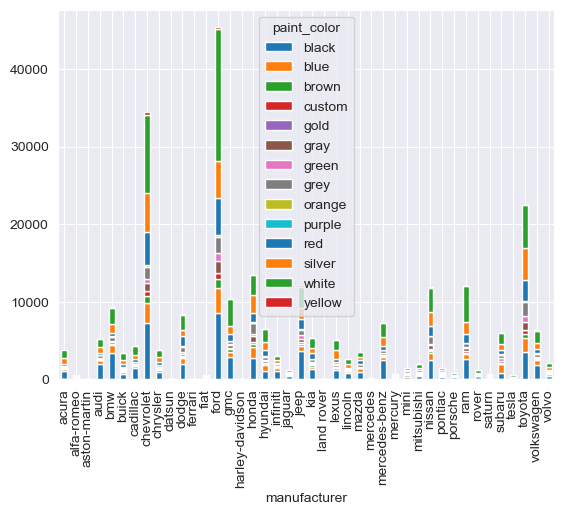

In [26]:
pd.crosstab(processed_test['manufacturer'], processed_test['paint_color']).plot.bar(stacked=True)

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, state_popularity_threshold=0.15, color_popularity_threshold=0.1):
        self.state_popularity_threshold = state_popularity_threshold
        self.color_popularity_threshold = color_popularity_threshold
        self.state_popularity_ = None
        self.common_colors_ = None
        self.popular_models = None
        
    def fit(self, X, y=None):
        # Calculate state popularity
        if 'state' in X.columns:
            state_counts = X['state'].value_counts(normalize=True)
            self.state_popularity_ = state_counts[state_counts > self.state_popularity_threshold].index.tolist()
        
        # Calculate color popularity
        if 'paint_color' in X.columns:
            color_counts = X['paint_color'].value_counts(normalize=True)
            self.common_colors_ = color_counts[color_counts > self.color_popularity_threshold].index.tolist()
            
        self.popular_models_ = X['model'].value_counts().head(20).index


    def transform(self, X):
        X = X.copy()


        current_year = pd.Timestamp.now().year
        X['car_age'] = current_year - X['year']
        X['is_recent_model'] = (X['car_age'] <= 3).astype(int)
        
        # 1. Car age
        current_year = pd.Timestamp.now().year
        X['car_age'] = current_year - X['year']

        # 2. Is car new
        X['is_car_new'] = (X['year'] >= 2018).astype(int)

        # 3. Posting month & quarter
        if 'posting_date' in X.columns:
            X['posting_date'] = pd.to_datetime(X['posting_date'], errors='coerce')
            X['posting_month'] = X['posting_date'].dt.month
            X['posting_quarter'] = X['posting_date'].dt.quarter
            
        # 4. State Popularity (using fit-learned states)
        if hasattr(self, 'state_popularity_') and 'state' in X.columns:
            X['is_popular_state'] = X['state'].isin(self.state_popularity_).astype(int)
            
        # 5. Vehicle Type Features
        if 'type' in X.columns:
            X['is_truck_or_suv'] = X['type'].isin(['truck', 'SUV']).astype(int)
            
        # 6. Engine Features
        if 'cylinders_numeric' in X.columns:
            X['has_many_cylinders'] = (X['cylinders_numeric'] >= 6).astype(int)
            
        # 7. Temporal Listing Patterns (safe)
        if 'posting_date' in X.columns:
            X['posting_date'] = pd.to_datetime(X['posting_date'], errors='coerce')
            X['posting_season'] = X['posting_date'].dt.quarter.map({
                1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'
            })
            # One-hot encode season
            seasons = pd.get_dummies(X['posting_season'], prefix='season')
            X = pd.concat([X, seasons], axis=1)
            
        # 7. Odometer Features
        if 'odometer' in X.columns:
            X['mileage_category'] = pd.cut(
                X['odometer'],
                bins=[1500, 30000, 60000, 100000, float('inf')],
                labels=['low', 'medium', 'high', 'very_high']
            )
            
        # 8. Color Popularity
        if hasattr(self, 'common_colors_') and 'paint_color' in X.columns:
            X['is_common_color'] = X['paint_color'].isin(self.common_colors_).astype(int)
            X['is_rare_color'] = (~X['paint_color'].isin(self.common_colors_)).astype(int)
            
        # 9. Geographic Features
        if all(col in X.columns for col in ['lat', 'long']):
            # US regions (approximate)
            X['is_northeast'] = ((X['lat'] >= 40) & (X['long'] >= -80)).astype(int)
            X['is_west_coast'] = ((X['lat'] <= 42) & (X['long'] <= -114)).astype(int)
            X['is_south'] = ((X['lat'] <= 35) & (X['long'] >= -100)).astype(int)
            
            # Population density proxy
            X['is_urban_area'] = ((X['lat'].between(30, 47)) & 
                                 (X['long'].between(-85, -118))).astype(int)
            
        # 9. Condition Features
        if 'condition' in X.columns:
            condition_rank = {
            'salvage': 0,
            'fair': 1,
            'good': 2,
            'commercial': 3,
            'excellent': 4,
            'like new': 5,
            'new': 6
        }
            X['condition_score'] = X['condition'].map(condition_rank).fillna(2)
        
        # 10. Transmission Features
        if 'transmission' in X.columns:
            X['is_automatic'] = X['transmission'].str.contains('auto', case=False).astype(int)
            
        # 11. Title Status Features
        if 'title_status' in X.columns:
            X['is_clean_title'] = X['title_status'].str.contains('clean', case=False).astype(int)
            
        # 12. Manufacturer Features   
        if 'manufacturer' in X.columns:
            domestic_brands = ['ford', 'chevrolet', 'dodge', 'jeep', 'tesla', 'gmc']
            X['is_domestic'] = X['manufacturer'].str.lower().isin(domestic_brands).astype(int)
                
        # 13. Popular models
        X['is_popular_model'] = X['model'].isin(self.popular_models_).astype(int)
        
        # 14. fuel efficiency
        if all(col in X.columns for col in ['cylinders_numeric', 'type']):
            X['fuel_efficiency'] = np.where(
            X['type'].isin(['sedan', 'hatchback']),
            30 - (X['cylinders_numeric'] * 2),  # Estimate MPG
            20 - (X['cylinders_numeric'] * 1.5)  # Trucks/SUVs
        )

        return X

In [27]:
# Initialize with threshold (e.g., states with >15% of listings are "popular")
fe = CarFeatureEngineer(
    state_popularity_threshold=0.15,  # States with >15% of listings
    color_popularity_threshold=0.1    # Colors with >10% occurrence
)

# Fit on training data only (to prevent leakage)
fe.fit(processed_test)

# Transform both train and test
X_train_fe  = fe.transform(processed_test)
X_val_fe  = fe.transform(processed_val)

print(X_train_fe.filter(regex='is_|category|score').columns)

X_train_fe.filter(regex='is_|category|score')

Index(['is_electric', 'is_recent_model', 'is_car_new', 'is_popular_state',
       'is_truck_or_suv', 'mileage_category', 'is_common_color',
       'is_rare_color', 'is_northeast', 'is_west_coast', 'is_south',
       'is_urban_area', 'condition_score', 'is_automatic', 'is_clean_title',
       'is_domestic', 'is_popular_model'],
      dtype='object')


,is_electric,is_recent_model,is_car_new,is_popular_state,is_truck_or_suv,mileage_category,is_common_color,is_rare_color,is_northeast,is_west_coast,is_south,is_urban_area,condition_score,is_automatic,is_clean_title,is_domestic,is_popular_model
0,0,0,0,0,1,very_high,0,1,0,0,0,0,1,1,1,0,0
1,0,0,0,0,0,NaN,0,1,0,0,1,0,0,1,1,1,0
2,0,0,0,0,1,low,1,0,0,1,0,0,4,1,1,1,0
3,0,0,1,0,0,medium,0,1,0,0,0,0,2,0,1,0,0
4,0,0,0,0,0,very_high,1,0,0,1,0,0,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273193,0,0,0,0,1,high,1,0,0,1,0,0,4,1,1,0,0
273194,0,0,0,0,1,NaN,1,0,0,0,1,0,2,1,1,1,0
273196,0,0,0,0,1,very_high,1,0,0,0,0,0,4,1,1,1,1
273199,0,0,0,0,0,high,1,0,0,0,0,0,4,1,1,1,0


Text(0.5, 1.0, 'Year Distribution After Imputation')

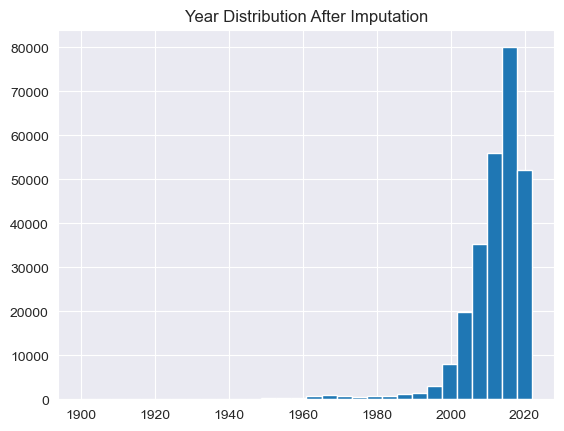

In [75]:
processed_test['year'].hist(bins=30)
plt.title("Year Distribution After Imputation")

In [148]:
# Select only numeric columns
num_cols = ['year', 'log_odometer', 'lat', 'long', 'cylinders_numeric']

# Check skewness
skewness = processed_test[num_cols].skew().sort_values(ascending=False)
print("Skewness:\n", skewness)

Skewness:
 lat                 -0.117163
cylinders_numeric   -0.606621
long                -0.647147
year                -3.512232
log_odometer        -3.688697
dtype: float64


In [149]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outlier_mask

# Example usage:
for col in num_cols:
    outliers = detect_outliers_iqr(processed_test, col)
    print(f"{col}: {outliers.sum()} outliers")


year: 8333 outliers
log_odometer: 12812 outliers
lat: 3981 outliers
long: 124 outliers
cylinders_numeric: 0 outliers


In [150]:
from scipy.stats import zscore

z_scores = processed_test[num_cols].apply(zscore)
outliers_z = (z_scores.abs() > 3).sum()
print("Outliers by Z-score:\n", outliers_z)

Outliers by Z-score:
 year                 5122
log_odometer         5721
lat                  2694
long                 3556
cylinders_numeric     179
dtype: int64


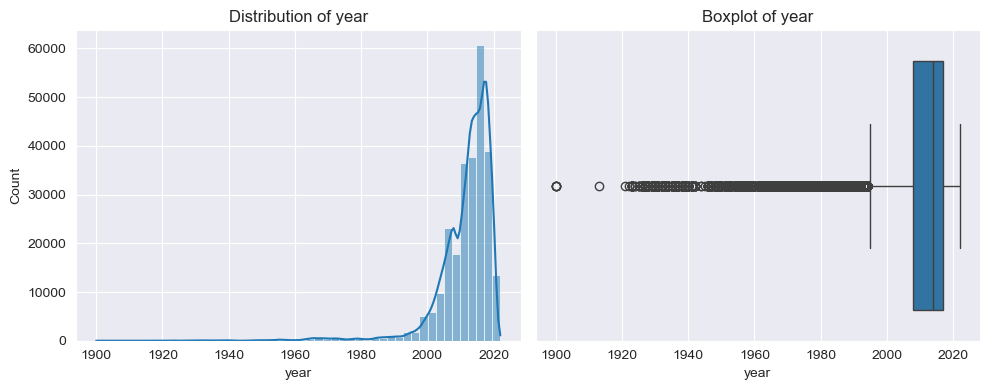

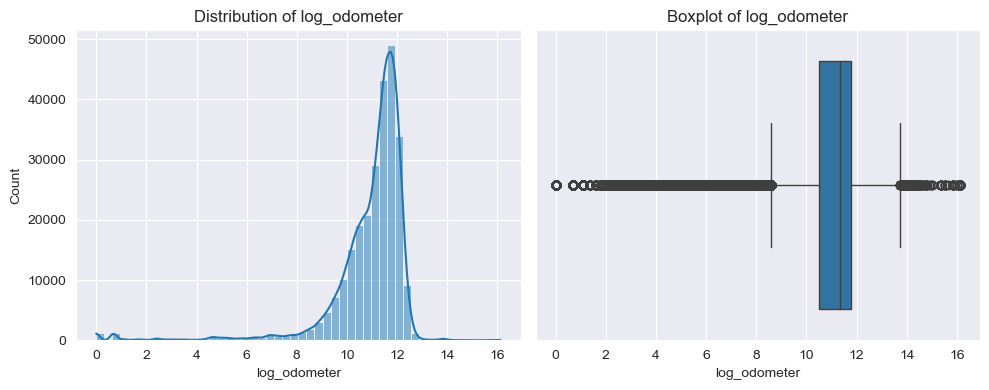

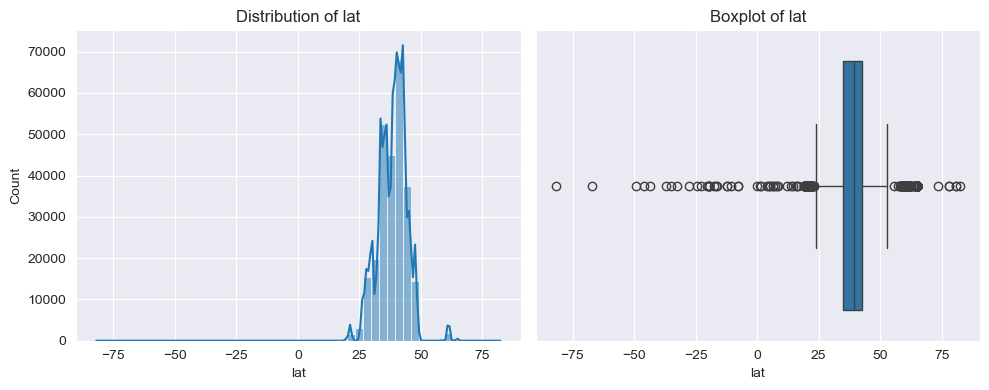

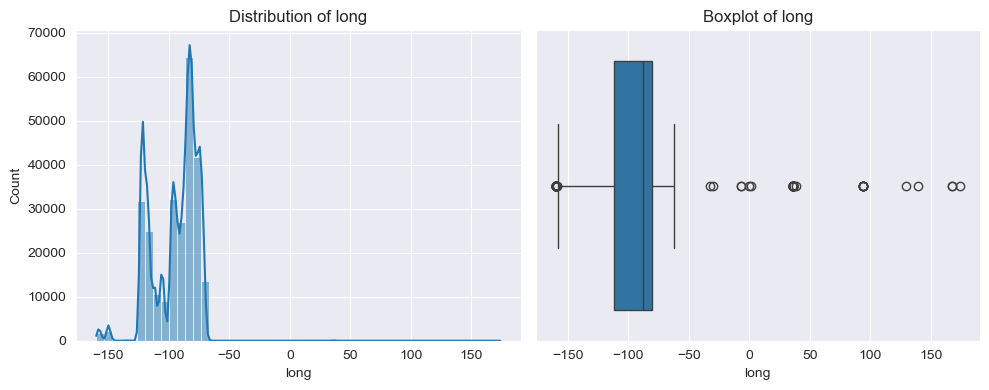

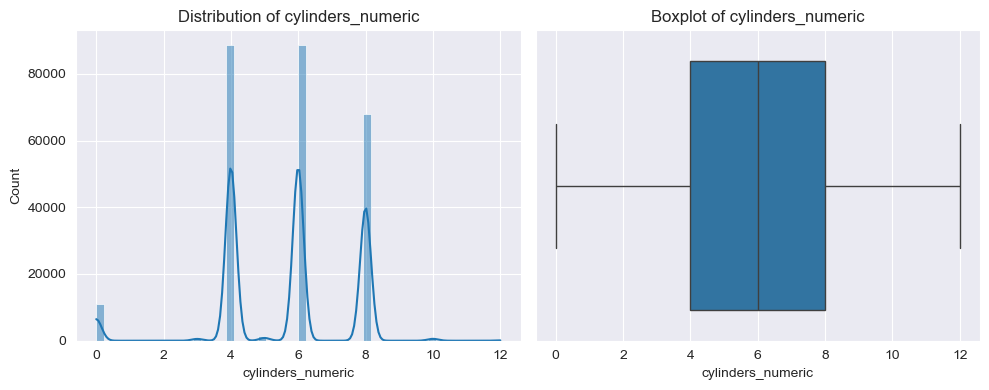

In [151]:
import seaborn as sns

cols = ['year', 'log_odometer', 'lat', 'long', 'cylinders_numeric']

for col in cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(processed_test[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=processed_test[col])
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()